In [ ]:
!rm -rf /kaggle

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'objectdetectiondatasetcar:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3508995%2F6121764%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240212%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240212T135029Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D05f70c5cc3bf0217a8230eb1c084e3c4d61d400160fa378a5f71f50d5b3d4fc05e20c133c316b97835a0b532190e2e231881f732ac69cdbc9d52848fec107a711bbb21861d06a5bd07d8b6a647c3bfc2f78b1f069c961c4719785307f567a458392ec2a4b7bd373b1138ccdd4aebba518ad8d85f73f1e1073120056bb432fd3f2836256470924198ea80da49edc2ef56f4144bfd7f05ef85d00b51bee3651342bf5e1ee14bee779155ec8c8b70f3fdf8542e1e192db494b3bb4a59984264a0cebeb05eb8a46f8c2247adc6a6c1e4d099701b12764b904da8e8f06e9690180ac686b60fb3ea76f4c01a81935295455d12799b34854e8873b94cbd4d2e43cbebde'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 787239294 bytes downloaded
Downloaded and uncompressed: objectdetectiondatasetcar
Data source import complete.


### Pip install method (recommended)
%pip install ultralytics
!pip install ultralytics

In [ ]:
!pip install ultralytics squarify matplotlib opencv-python pandas seaborn xmltodict

In [ ]:
# Importing the required libraries
from ultralytics import YOLO
import squarify
import matplotlib.pyplot as plt
import cv2
import os
import random
import pandas as pd
import matplotlib.image as mpimg
import seaborn as sns
import shutil


sns.set_style('darkgrid')

%matplotlib inline

In [ ]:
# Define the paths to the images and labels directories
images_folder = "/kaggle/input/objectdetectiondatasetcar/car"
labels_folder = "/kaggle/input/objectdetectiondatasetcar/car/annotation"

# separate images into train, test and validation (repartition : 60% train, 20% test, 20% validation)
!rm -rf "/kaggle/input/objectdetectiondatasetcar/train"
!rm -rf "/kaggle/input/objectdetectiondatasetcar/test"
!rm -rf "/kaggle/input/objectdetectiondatasetcar/valid"


!mkdir "/kaggle/input/objectdetectiondatasetcar/train"
!mkdir "/kaggle/input/objectdetectiondatasetcar/test"
!mkdir "/kaggle/input/objectdetectiondatasetcar/valid"

!mkdir "/kaggle/input/objectdetectiondatasetcar/train/images"
!mkdir "/kaggle/input/objectdetectiondatasetcar/test/images"
!mkdir "/kaggle/input/objectdetectiondatasetcar/valid/images"

!mkdir "/kaggle/input/objectdetectiondatasetcar/train/labels"
!mkdir "/kaggle/input/objectdetectiondatasetcar/test/labels"
!mkdir "/kaggle/input/objectdetectiondatasetcar/valid/labels"

# copy images into dirs
# Define the paths to the images and labels directories
images_folder = "/kaggle/input/objectdetectiondatasetcar/car"
labels_folder = "/kaggle/input/objectdetectiondatasetcar/car/annotation"

# Define paths to train, test, and validation directories
train_images = "/kaggle/input/objectdetectiondatasetcar/train/images"
test_images = "/kaggle/input/objectdetectiondatasetcar/test/images"
valid_images = "/kaggle/input/objectdetectiondatasetcar/valid/images"

# Define paths to corresponding label directories
train_labels = "/kaggle/input/objectdetectiondatasetcar/train/labels"
test_labels = "/kaggle/input/objectdetectiondatasetcar/test/labels"
valid_labels = "/kaggle/input/objectdetectiondatasetcar/valid/labels"

# Percentage split for train, test, and validation
train_percent = 0.6
test_percent = 0.2
valid_percent = 0.2

# Get a list of all image files
image_files = os.listdir(images_folder)

# Shuffle the list randomly
random.shuffle(image_files)

# Calculate split sizes
num_images = len(image_files)
num_train = int(train_percent * num_images)
num_test = int(test_percent * num_images)

# Split the image files into train, test, and validation sets
train_images_list = image_files[:num_train]
test_images_list = image_files[num_train:num_train + num_test]
valid_images_list = image_files[num_train + num_test:]

# Function to copy images and labels to their respective directories
def copy_images_and_labels(image_list, source_folder, dest_image_folder, dest_label_folder):
    for image_file in image_list:
        try:
          # Copy images
          src_image_path = os.path.join(source_folder, image_file)
          dest_image_path = os.path.join(dest_image_folder, image_file)
          shutil.copy(src_image_path, dest_image_path)

          # Copy labels
          label_file = os.path.splitext(image_file)[0] + ".xml"
          src_label_path = os.path.join(labels_folder, label_file)
          dest_label_path = os.path.join(dest_label_folder, label_file)
          shutil.copy(src_label_path, dest_label_path)
        except:
          continue

# Copy images and labels to train directories
copy_images_and_labels(train_images_list, images_folder, train_images, train_labels)

# Copy images and labels to test directories
copy_images_and_labels(test_images_list, images_folder, test_images, test_labels)

# Copy images and labels to validation directories
copy_images_and_labels(valid_images_list, images_folder, valid_images, valid_labels)

print("Images and labels copied to train, test, and validation directories successfully!")

Copied to  /kaggle/input/objectdetectiondatasetcar/train/images/10225.png
Copied to  /kaggle/input/objectdetectiondatasetcar/train/images/102600264.png
Copied to  /kaggle/input/objectdetectiondatasetcar/train/images/10260034.png
Copied to  /kaggle/input/objectdetectiondatasetcar/train/images/102600129.png
Copied to  /kaggle/input/objectdetectiondatasetcar/train/images/1024.png
Copied to  /kaggle/input/objectdetectiondatasetcar/train/images/102590.png
Copied to  /kaggle/input/objectdetectiondatasetcar/train/images/83.png
Copied to  /kaggle/input/objectdetectiondatasetcar/train/images/7.png
Copied to  /kaggle/input/objectdetectiondatasetcar/train/images/102600212.png
Copied to  /kaggle/input/objectdetectiondatasetcar/train/images/102600162.png
Copied to  /kaggle/input/objectdetectiondatasetcar/train/images/5.png
Copied to  /kaggle/input/objectdetectiondatasetcar/train/images/102600219.png
Copied to  /kaggle/input/objectdetectiondatasetcar/train/images/102600150.png
Copied to  /kaggle/inp

In [ ]:
print(images_folder)
print(train_images)

/kaggle/input/objectdetectiondatasetcar/car
['10260025.png', '35.png', '10222.png', '102600255.png', '10260094.png', '102600195.png', '102600201.png', '102600167.png', '73.png', '14.png', '10260015.png', '10260045.png', '102600256.png', '67.png', '102600137.png', '102600270.png', '10260096.png', '102583.png', '46.png', '102600236.png', '83.png', '102600178.png', '10260028.png', '102600104.png', '10260085.png', '1026000.png', '49.png', '10260081.png', '10260090.png', '10217.png', '30.png', '1026.png', '10260079.png', '50.png', '102600182.png', '10260075.png', '102600202.png', '102558.png', '86.png', '102600148.png', '96.png', '10260093.png', '102600160.png', '1028.png', '10260053.png', '10260041.png', '47.png', '6.png', '64.png', '10260035.png', '10260043.png', '10227.png', '22.png', '9.png', '102574.png', '78.png', '102600143.png', '102600264.png', '102600110.png', '102586.png', '88.png', '10260071.png', '102600115.png', '102575.png', '102595.png', '66.png', '57.png', '1026009.png', '1

In [ ]:
import os
import xml.etree.ElementTree as ET

def convert_xml_to_yolo(xml_dir, image_dir, yolo_txt_dir, class_mapping):
    for filename in os.listdir(xml_dir):
        if filename.endswith(".xml"):
            xml_file_path = os.path.join(xml_dir, filename)
            image_file_path = os.path.join(image_dir, filename.replace(".xml", ".png"))  # Adjust the extension as per your image files

            try:
                tree = ET.parse(xml_file_path)
                root = tree.getroot()

                # Check if the elements exist
                size_elem = root.find('size')
                if size_elem is None:
                    print(f"Error: 'size' element not found in {filename}")
                    delete_files([xml_file_path, image_file_path])
                    continue

                width_elem = size_elem.find('width')
                height_elem = size_elem.find('height')
                if width_elem is None or height_elem is None:
                    print(f"Error: 'width' or 'height' not found in {filename}")
                    delete_files([xml_file_path, image_file_path])
                    continue

                # Extract image width and height
                img_width = int(width_elem.text)
                img_height = int(height_elem.text)

                yolo_txt_path = os.path.join(yolo_txt_dir, filename.replace(".xml", ".txt"))

                with open(yolo_txt_path, 'w') as file:
                    for obj in root.findall('object'):
                        class_name = obj.find('name').text
                        class_id = class_mapping.get(class_name)

                        if class_id is not None:
                            bbox = obj.find('bndbox')
                            if bbox is None:
                                print(f"Error: 'bndbox' not found for object in {filename}")
                                delete_files([xml_file_path, image_file_path])
                                continue

                            x_min = int(bbox.find('xmin').text)
                            y_min = int(bbox.find('ymin').text)
                            x_max = int(bbox.find('xmax').text)
                            y_max = int(bbox.find('ymax').text)

                            x_center = (x_min + x_max) / 2 / img_width
                            y_center = (y_min + y_max) / 2 / img_height
                            width = (x_max - x_min) / img_width
                            height = (y_max - y_min) / img_height

                            file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
                delete_files([xml_file_path, image_file_path])

def delete_files(file_paths):
    for file_path in file_paths:
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"Deleted file: {file_path}")
        else:
            print(f"File not found: {file_path}")

class_mapping = {
    'car': 0,
}
convert_xml_to_yolo(train_labels,train_images, train_labels, class_mapping)
convert_xml_to_yolo(test_labels,test_images, test_labels, class_mapping)
convert_xml_to_yolo(valid_labels,valid_images, valid_labels, class_mapping)


Error: 'size' element not found in 102600174.xml
Deleted file: /kaggle/input/objectdetectiondatasetcar/train/labels/102600174.xml
Deleted file: /kaggle/input/objectdetectiondatasetcar/train/images/102600174.png
Error: 'size' element not found in 10260050.xml
Deleted file: /kaggle/input/objectdetectiondatasetcar/train/labels/10260050.xml
Deleted file: /kaggle/input/objectdetectiondatasetcar/train/images/10260050.png
Error: 'size' element not found in 102600189.xml
Deleted file: /kaggle/input/objectdetectiondatasetcar/train/labels/102600189.xml
Deleted file: /kaggle/input/objectdetectiondatasetcar/train/images/102600189.png
Error: 'size' element not found in 102576.xml
Deleted file: /kaggle/input/objectdetectiondatasetcar/train/labels/102576.xml
Deleted file: /kaggle/input/objectdetectiondatasetcar/train/images/102576.png
Error: 'size' element not found in 10260030.xml
Deleted file: /kaggle/input/objectdetectiondatasetcar/train/labels/10260030.xml
Deleted file: /kaggle/input/objectdetect

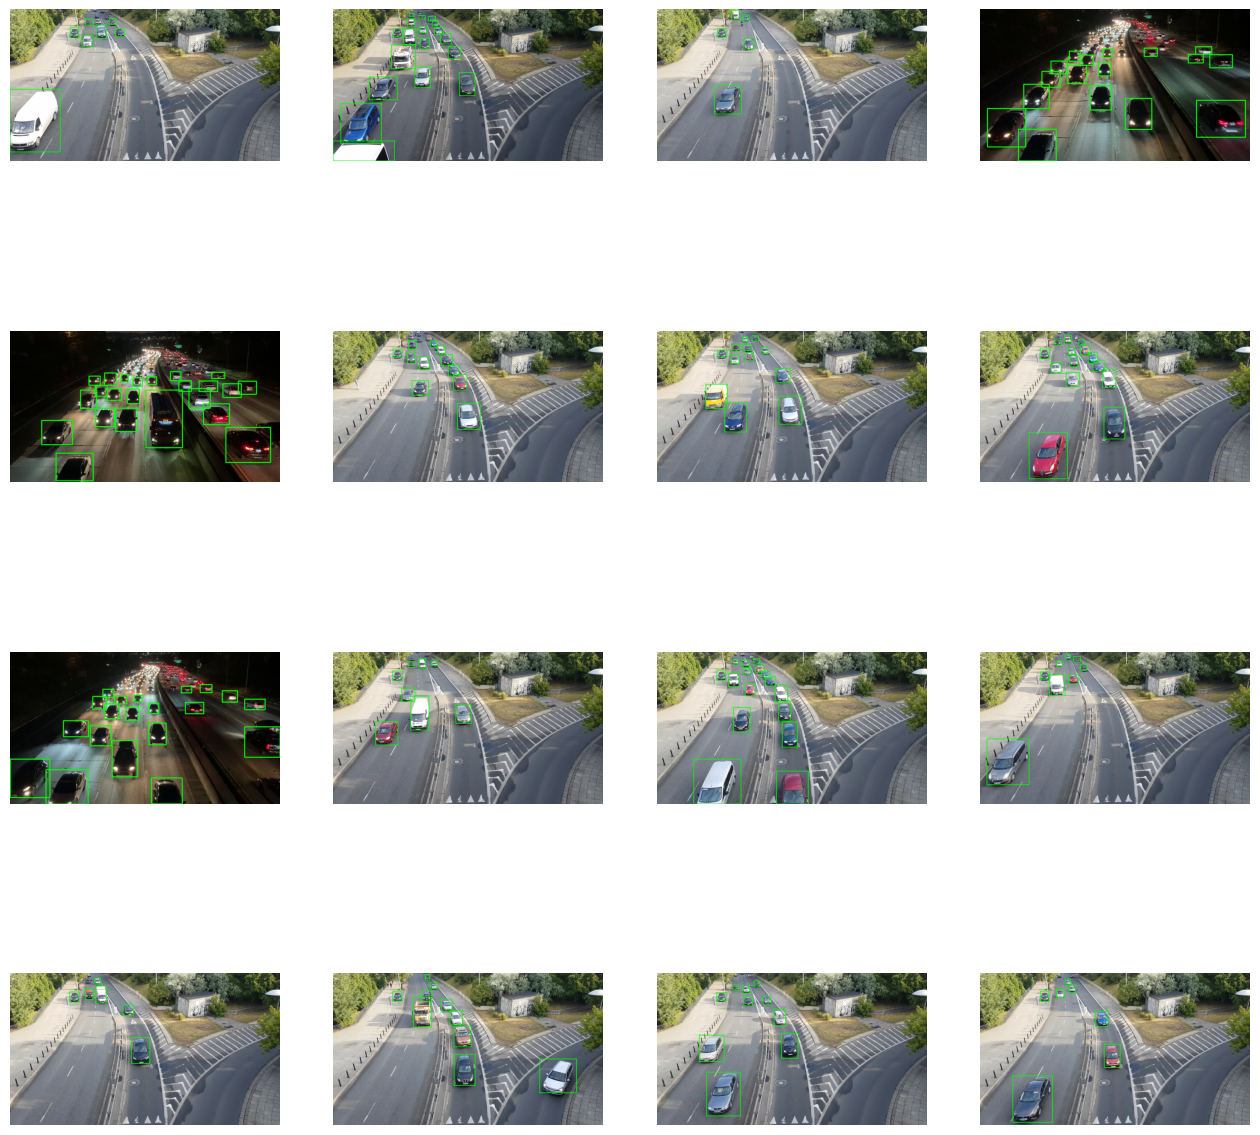

In [ ]:
train_images = "/kaggle/input/objectdetectiondatasetcar/train/images"
test_images = "/kaggle/input/objectdetectiondatasetcar/test/images"
valid_images = "/kaggle/input/objectdetectiondatasetcar/valid/images"

# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4

    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)


    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

In [ ]:
# Load an image using OpenCV
image = cv2.imread("/kaggle/input/objectdetectiondatasetcar/test/images/10.png")

# Get the size of the image
height, width, channels = image.shape
print(f"The image has dimensions {width}x{height} and {channels} channels.")

The image has dimensions 1920x1080 and 3 channels.


In [ ]:
# Define the path to the data.yaml file
yaml_file_path = "/kaggle/input/objectdetectiondatasetcar/data.yaml"

# Define the content of the data.yaml file as a string
yaml_content = """
train: /kaggle/input/objectdetectiondatasetcar/train/images
val: /kaggle/input/objectdetectiondatasetcar/valid/images
nc: 1
names: ['car']
"""

# Write the content to the data.yaml file
with open(yaml_file_path, 'w') as yaml_file:
    yaml_file.write(yaml_content)

print("data.yaml file created successfully!")

data.yaml file created successfully!


In [ ]:
 # Loading a pretrained model
model = YOLO('yolov8x.pt')

# Training the model
model.train(data = '/kaggle/input/objectdetectiondatasetcar/data.yaml',
            epochs = 25,
            imgsz = 256,
            batch = -1)

100%|██████████| 131M/131M [00:00<00:00, 210MB/s]


Ultralytics YOLOv8.1.11 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/kaggle/input/objectdetectiondatasetcar/data.yaml, epochs=50, time=None, patience=50, batch=-1, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True,

100%|██████████| 755k/755k [00:00<00:00, 45.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 179MB/s]


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=256
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.57G reserved, 0.56G allocated, 13.62G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    68153571        41.3         0.870         51.54         149.8        (1, 3, 256, 256)                    list
    68153571        82.6         0.971         29.28         67.54        (2, 3, 256, 256)                    list
    68153571       165.2         1.187         30.27         58.42        (4, 3, 256, 256)                    list
    68153571       330.4         1.648         32.49          61.2        (8, 3, 256, 256)                    list
    68153571       660.8         2.592          58.5         81.78       (16, 3, 256, 256)                    list
AutoBatch: Using batch-size 64 for CUDA:0 9.25G/14.75G (63%) ✅


train: Scanning /kaggle/input/objectdetectiondatasetcar/train/labels... 83 images, 2 backgrounds, 0 corrupt: 100%|██████████| 84/84 [00:00<00:00, 157.72it/s]

train: New cache created: /kaggle/input/objectdetectiondatasetcar/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/objectdetectiondatasetcar/valid/labels... 26 images, 0 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<00:00, 93.46it/s] 

val: New cache created: /kaggle/input/objectdetectiondatasetcar/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      8.89G      1.635      3.493      1.073        532        256: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.69s/it]

                   all         26        335      0.544      0.296      0.358       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.89G       1.67       3.55       1.06        420        256: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         26        335      0.505      0.374      0.355      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.93G      1.741      3.526      1.063        478        256: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]

                   all         26        335      0.539      0.282      0.343      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.93G      1.712      3.512       1.05        562        256: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


                   all         26        335      0.293       0.57      0.226      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.49G      1.412      1.859     0.9554        477        256: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all         26        335       0.65      0.716      0.722      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.49G      1.267     0.7984     0.9185        414        256: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         26        335      0.425      0.693       0.39      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.51G      1.301     0.7769     0.9269        464        256: 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         26        335      0.776      0.794      0.808      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.48G      1.327     0.7297     0.9178        412        256: 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

                   all         26        335      0.328      0.833      0.312       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       9.5G      1.296     0.6687      0.908        423        256: 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         26        335      0.143      0.845      0.139     0.0746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.51G      1.257     0.6379     0.9003        418        256: 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

                   all         26        335      0.177      0.863      0.179     0.0908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.47G      1.248     0.6397     0.8966        469        256: 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         26        335      0.507      0.412      0.366      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.51G      1.205     0.6045      0.899        404        256: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all         26        335      0.388      0.466      0.245       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.51G      1.193     0.6518      0.889        415        256: 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


                   all         26        335    0.00412     0.0955    0.00241   0.000659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.49G       1.12     0.5524     0.8887        399        256: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

                   all         26        335    0.00474       0.11    0.00312   0.000555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       9.5G      1.175     0.5641     0.8793        457        256: 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         26        335    0.00538      0.125    0.00332   0.000687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.48G      1.171     0.5725     0.8785        424        256: 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


                   all         26        335     0.0059      0.137      0.004   0.000916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       9.5G      1.163     0.5827     0.8786        543        256: 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]

                   all         26        335    0.00641      0.149    0.00481   0.000975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       9.5G      1.184     0.5844     0.8757        442        256: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         26        335     0.0155      0.176     0.0079    0.00378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.51G      1.167     0.5586     0.8761        446        256: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


                   all         26        335     0.0401      0.284     0.0222     0.0134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.47G      1.075     0.5637     0.8694        407        256: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

                   all         26        335      0.031      0.445     0.0217     0.0128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      9.49G      1.187     0.5567     0.8774        514        256: 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         26        335      0.146      0.501      0.103     0.0535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       9.5G      1.175     0.5784     0.8909        421        256: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

                   all         26        335      0.692      0.757       0.71      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.49G      1.203     0.5681     0.8831        533        256: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

                   all         26        335      0.768      0.812      0.825      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.52G      1.141     0.5359     0.8744        434        256: 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         26        335      0.734      0.821      0.801      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       9.5G      1.226     0.5868     0.8698        464        256: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

                   all         26        335      0.765      0.718      0.775      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.53G      1.156     0.5793     0.8838        413        256: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         26        335      0.755      0.761      0.781       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.47G      1.134     0.5653     0.8756        378        256: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

                   all         26        335      0.447      0.338      0.255      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      9.48G      1.199     0.6142     0.8825        468        256: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         26        335     0.0442      0.343     0.0271     0.0125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.47G      1.152     0.5499     0.8612        468        256: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         26        335     0.0293      0.322     0.0183     0.0087



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.49G       1.16      0.533     0.8866        452        256: 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         26        335     0.0396      0.361      0.026     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.47G      1.114     0.5218     0.8707        472        256: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]

                   all         26        335      0.097      0.457     0.0706     0.0372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       9.5G      1.103     0.5207      0.867        449        256: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         26        335     0.0762      0.606     0.0616     0.0345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.54G      1.149     0.5401     0.8535        504        256: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


                   all         26        335     0.0256      0.403     0.0177    0.00996

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.51G      1.118     0.5305     0.8656        466        256: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         26        335     0.0615      0.546     0.0459      0.027



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       9.5G      1.095      0.531     0.8668        466        256: 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         26        335      0.244      0.648      0.194       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       9.5G      1.116     0.5268     0.8662        397        256: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         26        335       0.26      0.621      0.201      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       9.5G      1.094     0.5554      0.849        462        256: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

                   all         26        335      0.637      0.504      0.518      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       9.5G      1.064     0.5067     0.8421        453        256: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

                   all         26        335      0.759      0.567      0.664      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      9.51G      1.077     0.5435     0.8738        301        256: 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

                   all         26        335      0.692      0.501      0.576      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      9.49G      1.058     0.5196     0.8753        470        256: 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


                   all         26        335      0.621      0.457      0.518       0.29
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      9.41G       1.03     0.5023     0.8575        270        256: 100%|██████████| 2/2 [00:05<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         26        335      0.741      0.561      0.641      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       9.4G      1.001     0.4682     0.8489        264        256: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         26        335      0.801      0.609      0.693      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      9.41G     0.9805     0.5064      0.837        229        256: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         26        335      0.843      0.546      0.651      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.41G     0.9741     0.4838     0.8556        265        256: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         26        335      0.529      0.379      0.394      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       9.4G     0.9936     0.4847      0.853        231        256: 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         26        335      0.762      0.469      0.568      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.42G     0.9948     0.4724     0.8377        269        256: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]

                   all         26        335      0.799      0.628      0.712      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      9.41G     0.9707     0.4648     0.8411        282        256: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


                   all         26        335      0.807       0.69      0.768      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      9.41G     0.9754     0.4815     0.8437        264        256: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         26        335      0.829      0.749      0.816      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      9.41G     0.9937     0.4965     0.8422        217        256: 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         26        335       0.84      0.752      0.824      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      9.41G     0.9846     0.4729     0.8308        247        256: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

                   all         26        335      0.844      0.752      0.832      0.501



50 epochs completed in 0.131 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 136.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.11 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68124531 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


                   all         26        335      0.844      0.752      0.832      0.501
Speed: 0.0ms preprocess, 3.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7eaad55187f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

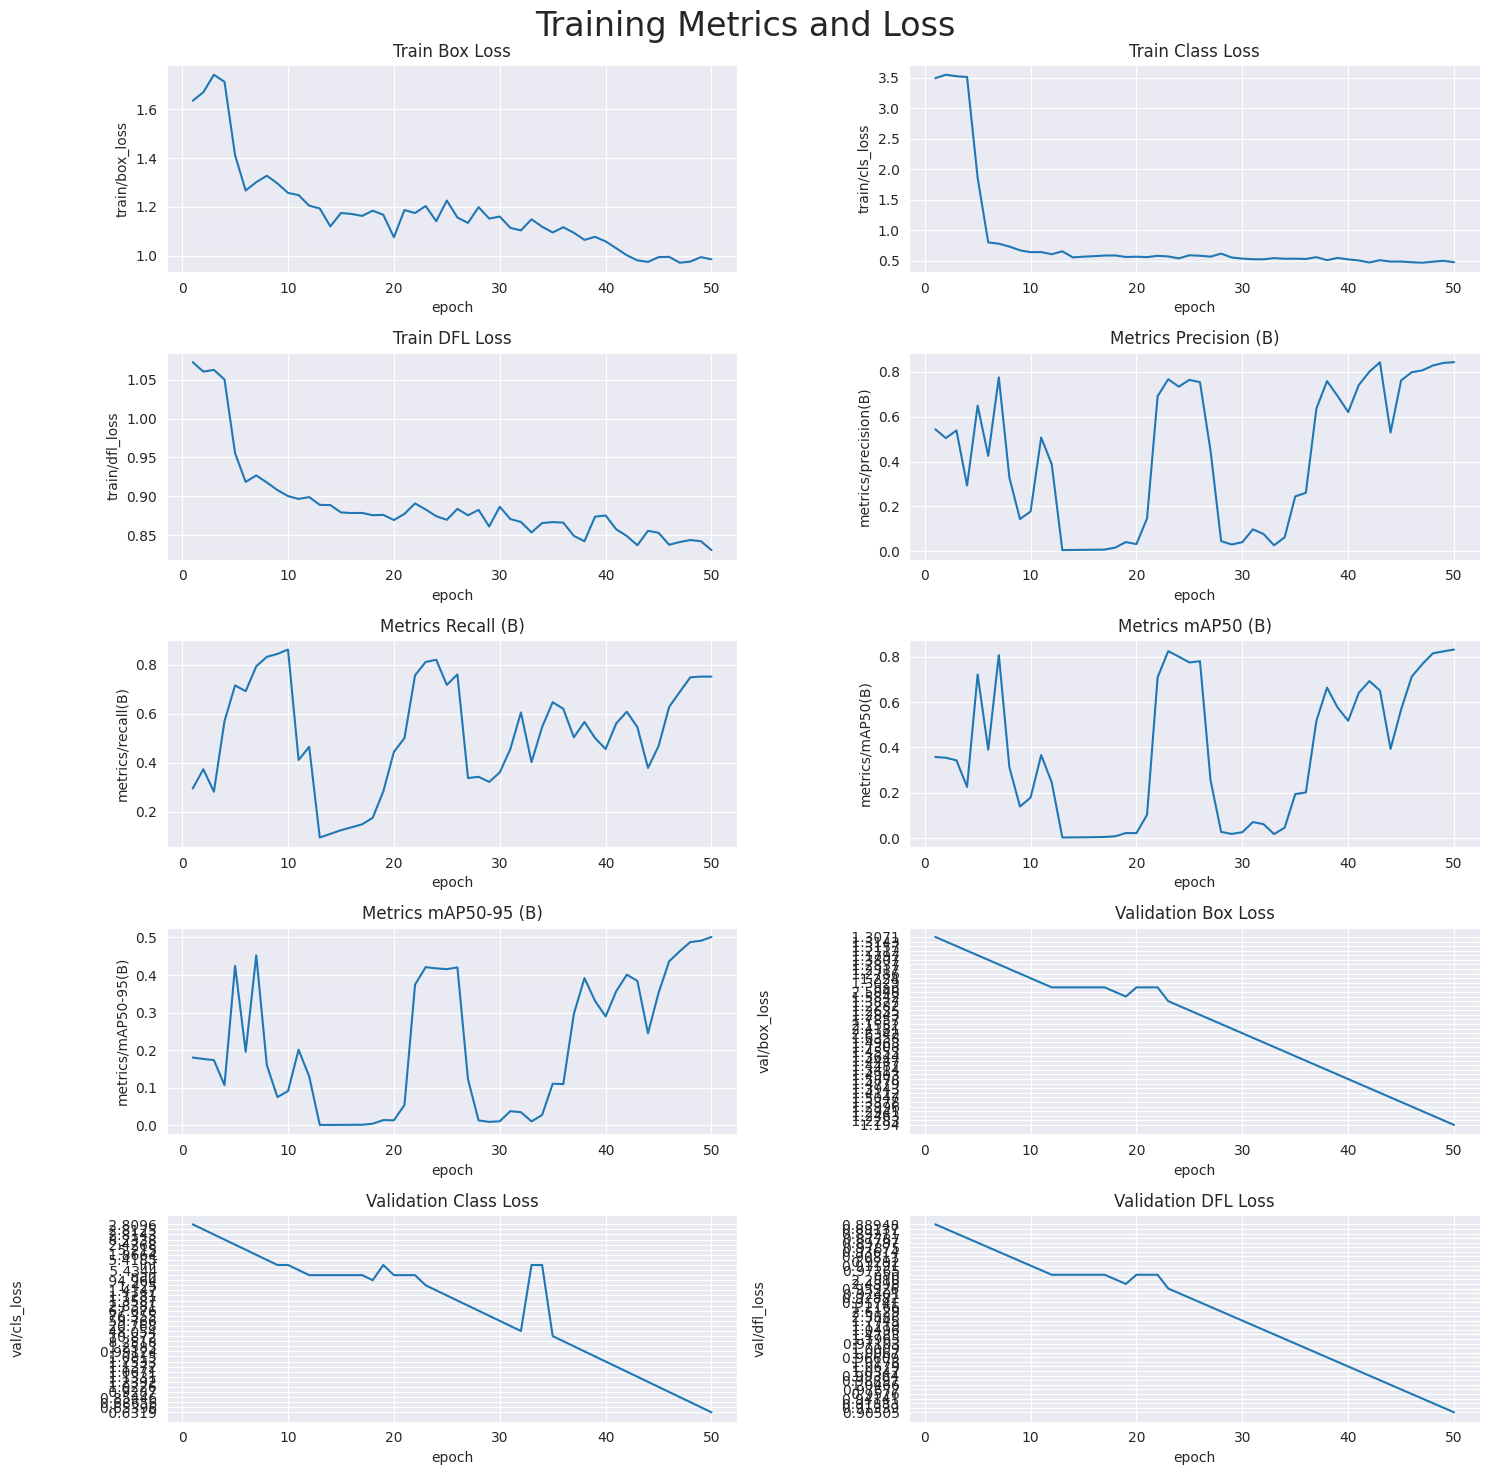

In [ ]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('runs/detect/train/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()


In [ ]:
%matplotlib inline
# Loading the best performing model
model = YOLO('runs/detect/train/weights/best.pt')

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25)

Ultralytics YOLOv8.1.11 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68124531 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /kaggle/input/objectdetectiondatasetcar/valid/labels.cache... 26 images, 0 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


                   all         26        335      0.869      0.731      0.814      0.552
Speed: 0.2ms preprocess, 33.3ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/val5


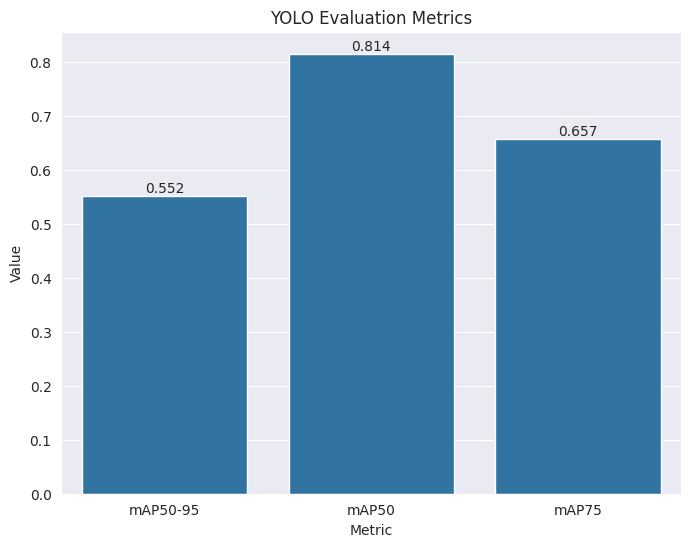

In [ ]:
%matplotlib inline
# Create the barplot
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Show the plot
plt.show()

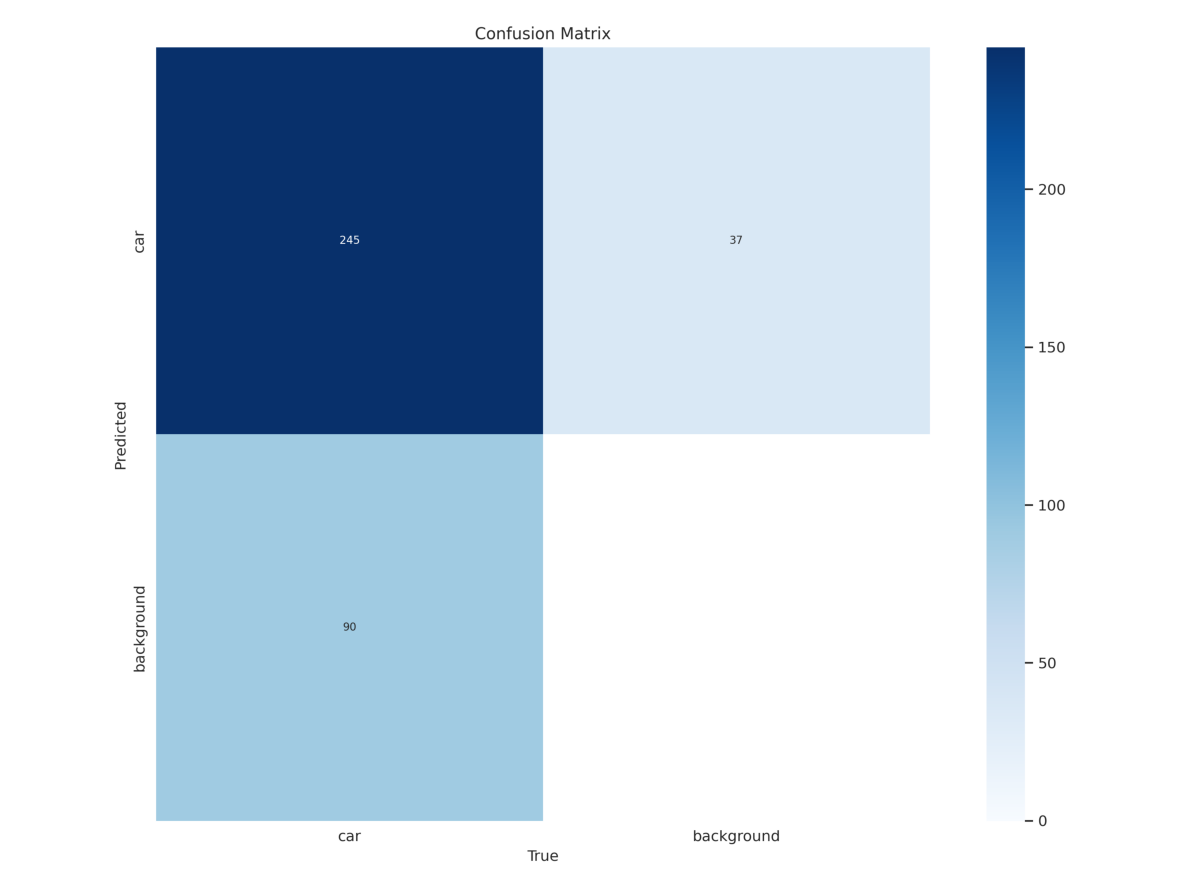

In [ ]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('runs/detect/train/confusion_matrix.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off');

In [ ]:
# Function to perform ship detections
def ship_detect(img_path):

    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections
    detect_img = detect_result[0].plot()

    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

    return detect_img


0: 160x256 4 cars, 96.6ms
Speed: 0.9ms preprocess, 96.6ms inference, 1.9ms postprocess per image at shape (1, 3, 160, 256)

0: 160x256 8 cars, 23.6ms
Speed: 1.7ms preprocess, 23.6ms inference, 1.4ms postprocess per image at shape (1, 3, 160, 256)

0: 160x256 6 cars, 24.9ms
Speed: 1.3ms preprocess, 24.9ms inference, 1.5ms postprocess per image at shape (1, 3, 160, 256)

0: 160x256 19 cars, 23.9ms
Speed: 1.4ms preprocess, 23.9ms inference, 1.4ms postprocess per image at shape (1, 3, 160, 256)

0: 160x256 6 cars, 23.7ms
Speed: 1.7ms preprocess, 23.7ms inference, 1.6ms postprocess per image at shape (1, 3, 160, 256)

0: 160x256 12 cars, 23.2ms
Speed: 2.0ms preprocess, 23.2ms inference, 1.5ms postprocess per image at shape (1, 3, 160, 256)

0: 160x256 8 cars, 24.5ms
Speed: 1.1ms preprocess, 24.5ms inference, 1.4ms postprocess per image at shape (1, 3, 160, 256)

0: 160x256 17 cars, 24.4ms
Speed: 1.0ms preprocess, 24.4ms inference, 2.3ms postprocess per image at shape (1, 3, 160, 256)

0: 1

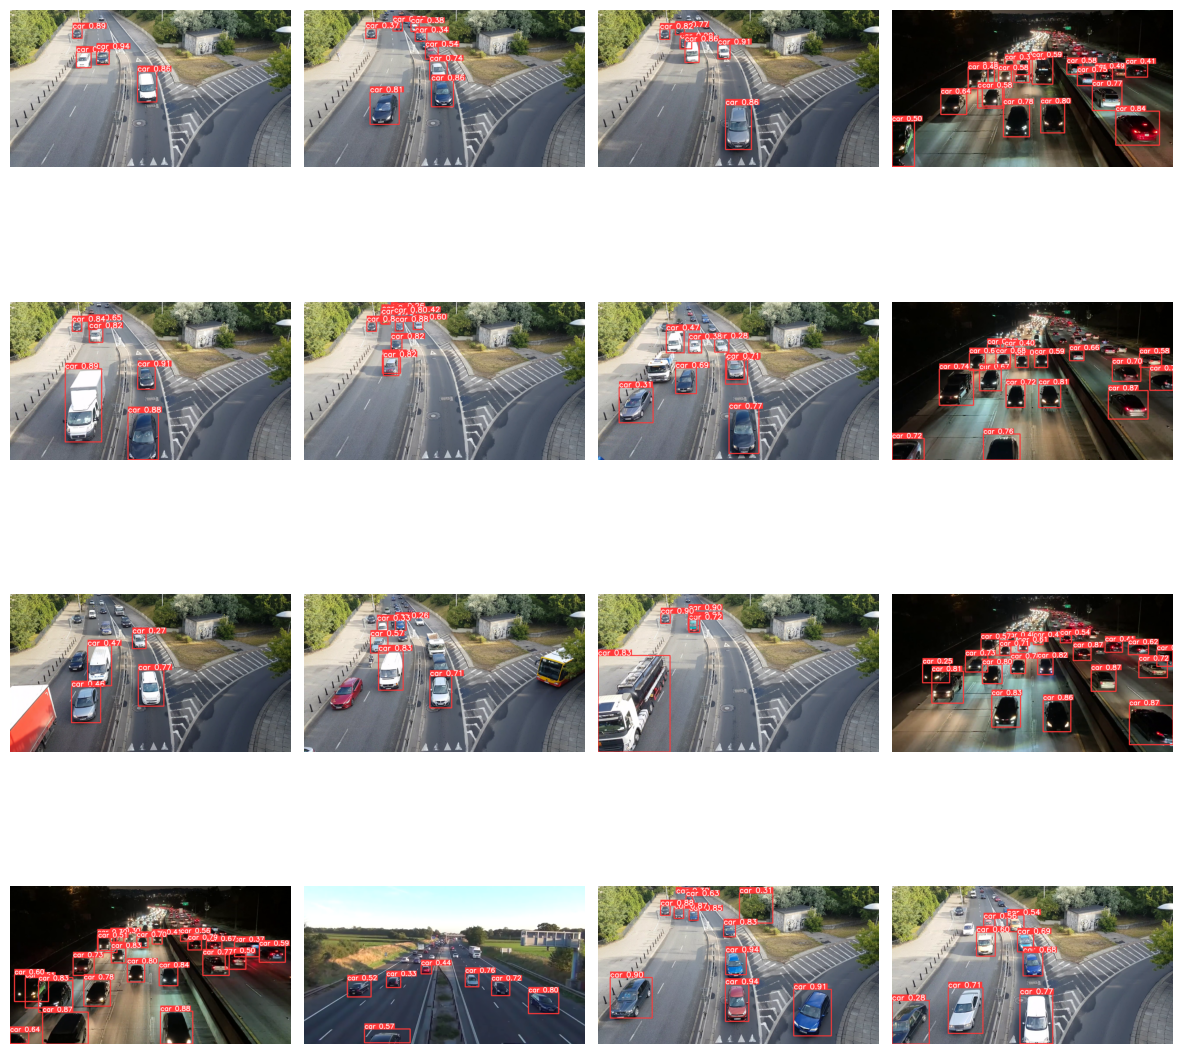

In [ ]:
import random

# Define the directory where the custom images are stored
custom_image_dir = '/kaggle/input/objectdetectiondatasetcar/test/images'

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 16)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):

    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4

    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = ship_detect(img_path)

    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)